In [1]:
import requests
import numpy as np
import matplotlib.pyplot as plt


# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

# Read content
data = np.genfromtxt("Summary_table.txt", dtype='str',autostrip=True)

# Read headers
with open("Summary_table.txt",'r') as f:
    names = np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])

[None, Text(0.5, 0, 'Redshift'), Text(0, 0.5, 'Counts')]

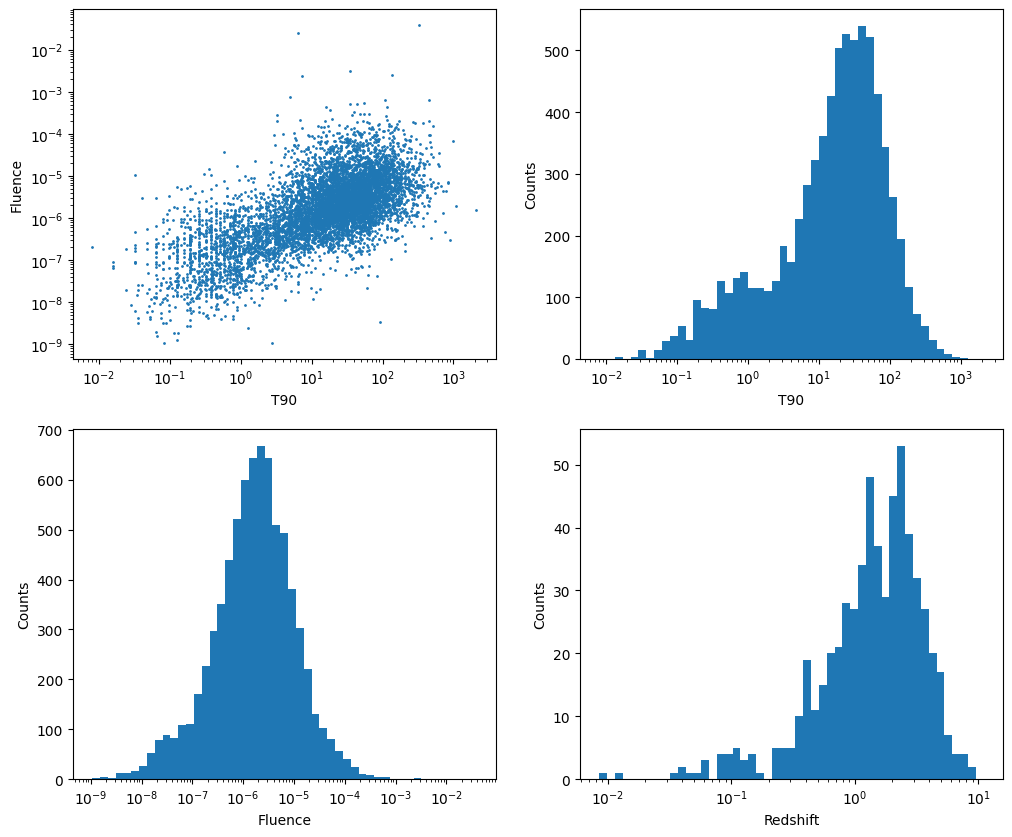

In [7]:
# plotting the distributions for T90, fluence and redshift
T90 = np.squeeze(data[:,names=='T90'].astype(float))
fluence = np.squeeze(data[:,names=='fluence'].astype(float))
redshift = np.squeeze(data[:,names=='redshift'].astype(float))

mask = (T90!=-999) & (fluence!=-999) & (fluence!=0) 

T90 = T90[mask]
fluence = fluence[mask]
redshift = redshift[mask]
logbins_T90 = np.logspace(np.log10(min(T90[T90>0])),np.log10(max(T90[T90>0])),50)
logbins_flu = np.logspace(np.log10(min(fluence[fluence>0])),np.log10(max(fluence[fluence>0])),50)
logbins_red = np.logspace(np.log10(min(redshift[redshift>0])),np.log10(max(redshift[redshift>0])),50)

fig,ax=plt.subplots(2,2,figsize=(12,10))


ax[0][0].plot(T90,fluence,marker='o',linestyle='',markersize=1)
ax[0][0].set(xscale='log',yscale='log',xlabel='T90',ylabel='Fluence')
logbins = np.logspace(np.log10(min(T90)),np.log10(max(T90)),50)
ax[0][1].hist(T90,bins=logbins_T90)
ax[0][1].set(xscale='log',xlabel='T90',ylabel='Counts')
ax[1][0].hist(fluence,bins=logbins_flu)
ax[1][0].set(xscale='log',xlabel='Fluence',ylabel='Counts')
ax[1][1].hist(redshift,bins=logbins_red)
ax[1][1].set(xscale='log',xlabel='Redshift',ylabel='Counts')

Probability of the blue cluster: 74.58% 
Probability of the blue cluster: 25.42%


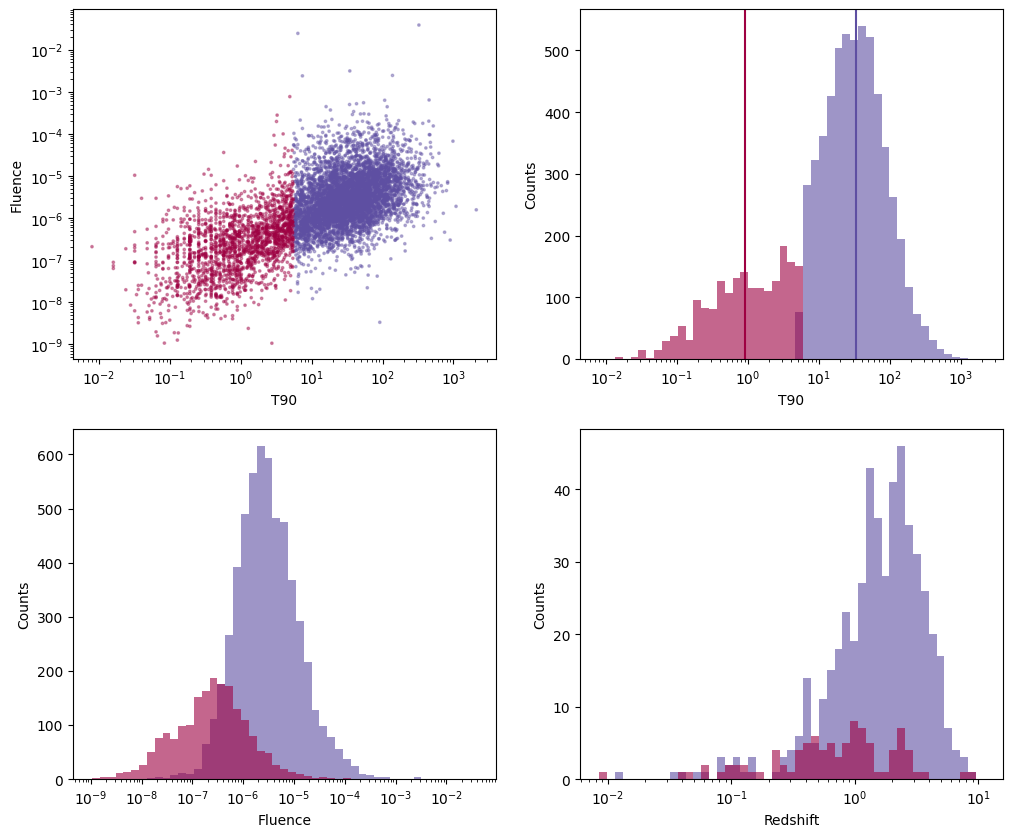

In [ ]:
# since T90 seems to be made of 2 different populations,
# let's use it to train our classifier, first with KMeans and then with GM
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
n_clus=2

T90_log = np.log10(T90)

pipe = make_pipeline(
    StandardScaler(),
    KMeans(n_clusters=n_clus, n_init='auto', random_state=42)
)
pipe.fit(T90_log[:,np.newaxis])

clf = pipe.named_steps['kmeans']
scaler = pipe.named_steps['standardscaler']

centers = 10**scaler.inverse_transform(clf.cluster_centers_) 

labels = pipe.predict(T90_log[:,np.newaxis])


fig,ax=plt.subplots(2,2,figsize=(12,10))
colors = plt.cm.Spectral(np.linspace(1, 0, len(centers)))

for i in range(len(centers)):
    ax[0][0].scatter(T90[labels==i],fluence[labels==i],color=colors[i],alpha=0.4,s=3,linestyle='')
    ax[0][1].hist(T90[labels==i],bins=logbins_T90,alpha=0.6,color=colors[i])
    ax[0][1].axvline(centers[i],color=colors[i],alpha=1)
    ax[1][0].hist(fluence[labels==i],bins=logbins_flu,alpha=0.6,color=colors[i])
    ax[1][1].hist(redshift[labels==i],bins=logbins_red,alpha=0.6,color=colors[i])
ax[0][0].set(xscale='log',yscale='log',xlabel='T90',ylabel='Fluence')
ax[0][1].set(xscale='log',xlabel='T90',ylabel='Counts')
ax[1][0].set(xscale='log',xlabel='Fluence',ylabel='Counts')
ax[1][1].set(xscale='log',xlabel='Redshift',ylabel='Counts')
print('Probability of the blue cluster: {:.2f}%'.format(100*np.count_nonzero(labels==0)/len(labels)),
      '\nProbability of the blue cluster: {:.2f}%'.format(100*np.count_nonzero(labels==1)/len(labels)))


Probability of the blue cluster: 78.27% 
Probability of the red cluster: 21.73%


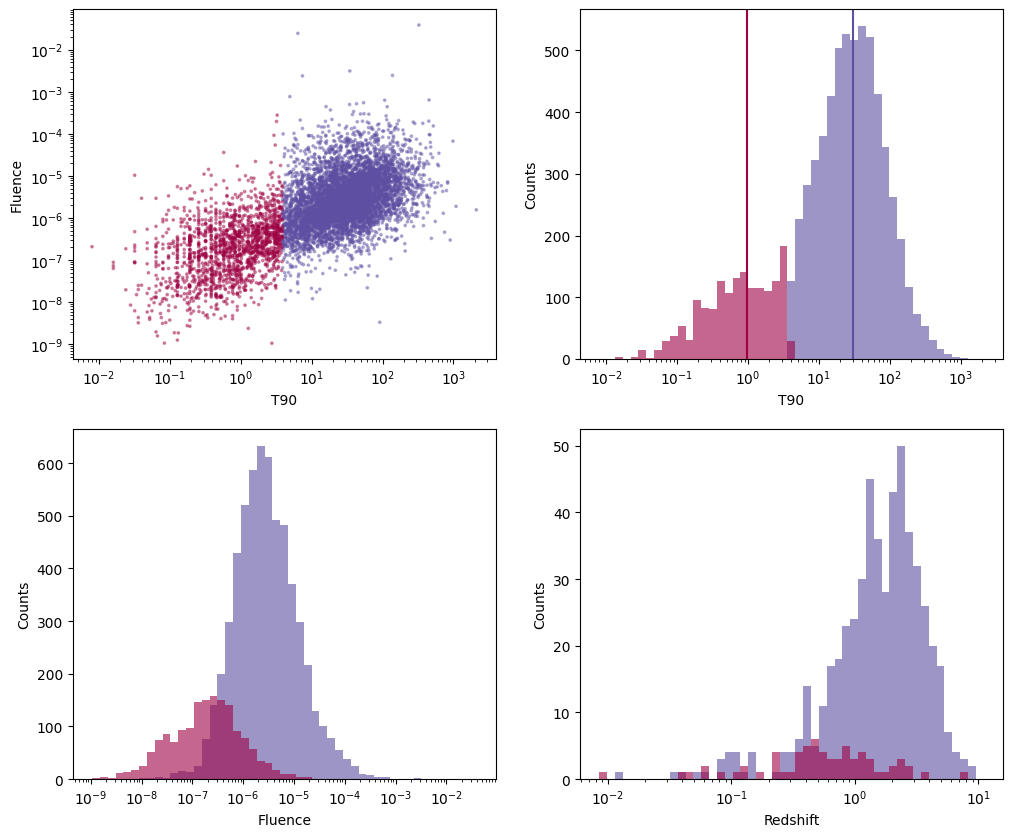

In [ ]:
from sklearn.mixture import GaussianMixture

pipe = make_pipeline(
    StandardScaler(),
    GaussianMixture(n_components=2,
                    covariance_type='full',
                    random_state=42)
)

pipe.fit(T90_log[:,np.newaxis])

labels = pipe.predict(T90_log[:, np.newaxis])

gmm = pipe.named_steps['gaussianmixture']
scaler = pipe.named_steps['standardscaler']

centers = 10**scaler.inverse_transform(gmm.means_).flatten()

fig,ax=plt.subplots(2,2,figsize=(12,10))
colors = plt.cm.Spectral(np.linspace(1,0, len(centers)))

for i in range(len(centers)):
    ax[0][0].scatter(T90[labels==i],fluence[labels==i],color=colors[i],alpha=0.4,s=3,linestyle='')
    ax[0][1].hist(T90[labels==i],bins=logbins_T90,alpha=0.6,color=colors[i])
    ax[0][1].axvline(centers[i],color=colors[i],alpha=1)
    ax[1][0].hist(fluence[labels==i],bins=logbins_flu,alpha=0.6,color=colors[i])
    ax[1][1].hist(redshift[labels==i],bins=logbins_red,alpha=0.6,color=colors[i])
ax[0][0].set(xscale='log',yscale='log',xlabel='T90',ylabel='Fluence')
ax[0][1].set(xscale='log',xlabel='T90',ylabel='Counts')
ax[1][0].set(xscale='log',xlabel='Fluence',ylabel='Counts')
ax[1][1].set(xscale='log',xlabel='Redshift',ylabel='Counts')
print('Probability of the blue cluster: {:.2f}%'.format(100*np.count_nonzero(labels==0)/len(labels)),
      '\nProbability of the red cluster: {:.2f}%'.format(100*np.count_nonzero(labels==1)/len(labels)))

Probability of the blue cluster: 72.66% 
Probability of the red cluster: 27.34%


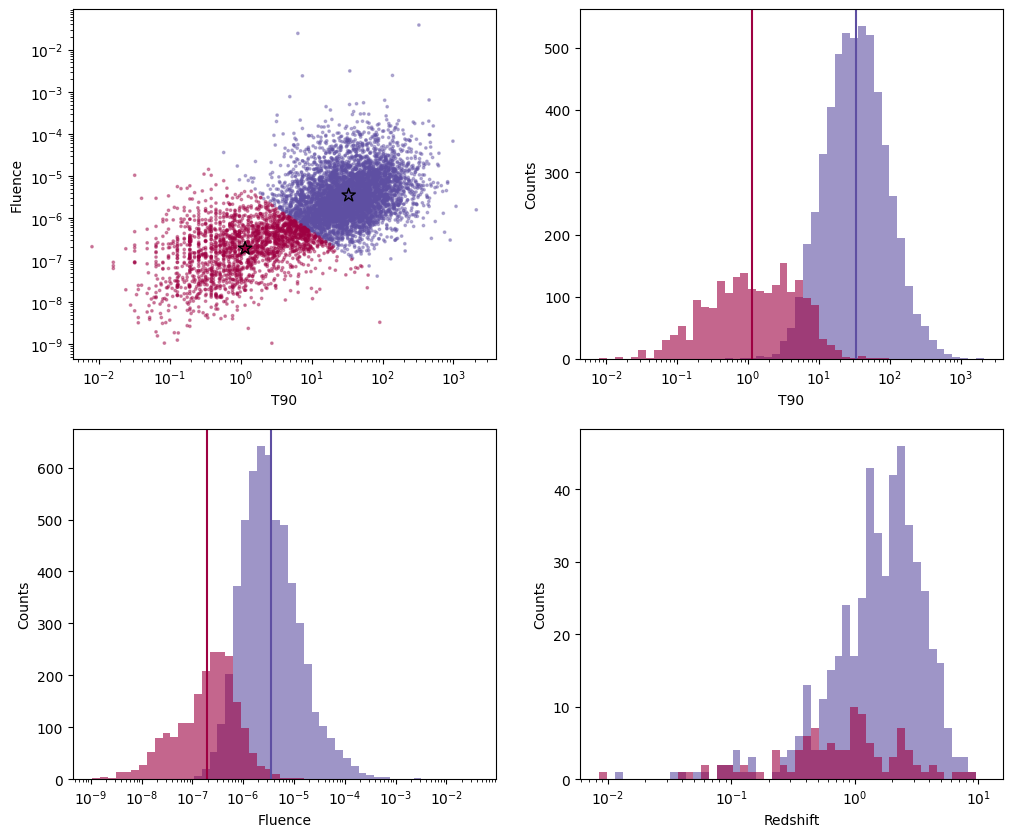

In [18]:
# this time, we try the same as before but using both T90 and fluence to do our classifications
n_clus=2
data_reduced = data[:,[6,9]].astype(float)
data_reduced_log = np.log10(data_reduced[mask])

pipe = make_pipeline(
    StandardScaler(),
    KMeans(n_clusters=n_clus, n_init='auto', random_state=42)
)
pipe.fit(data_reduced_log)

clf = pipe.named_steps['kmeans']
scaler = pipe.named_steps['standardscaler']

centers = 10**scaler.inverse_transform(clf.cluster_centers_) 

labels = pipe.predict(data_reduced_log)


fig,ax=plt.subplots(2,2,figsize=(12,10))
colors = plt.cm.Spectral(np.linspace(1, 0, len(centers)))

for i in range(len(centers)):
    ax[0][0].scatter(T90[labels==i],fluence[labels==i],color=colors[i],alpha=0.4,s=3,linestyle='')
    ax[0][1].hist(T90[labels==i],bins=logbins_T90,alpha=0.6,color=colors[i])
    ax[0][1].axvline(centers[i,0],color=colors[i],alpha=1)
    ax[1][0].hist(fluence[labels==i],bins=logbins_flu,alpha=0.6,color=colors[i])
    ax[1][0].axvline(centers[i,1],color=colors[i],alpha=1)
    ax[1][1].hist(redshift[labels==i],bins=logbins_red,alpha=0.6,color=colors[i])
ax[0][0].scatter(centers[:,0],centers[:,1],marker='*',edgecolors='black',c=colors[0:len(centers)],s=100,label='Centers')
ax[0][0].set(xscale='log',yscale='log',xlabel='T90',ylabel='Fluence')
ax[0][1].set(xscale='log',xlabel='T90',ylabel='Counts')
ax[1][0].set(xscale='log',xlabel='Fluence',ylabel='Counts')
ax[1][1].set(xscale='log',xlabel='Redshift',ylabel='Counts')
print('Probability of the blue cluster: {:.2f}%'.format(100*np.count_nonzero(labels==0)/len(labels)),
      '\nProbability of the red cluster: {:.2f}%'.format(100*np.count_nonzero(labels==1)/len(labels)))


Probability of the blue cluster: 77.22% 
Probability of the red cluster: 22.78%


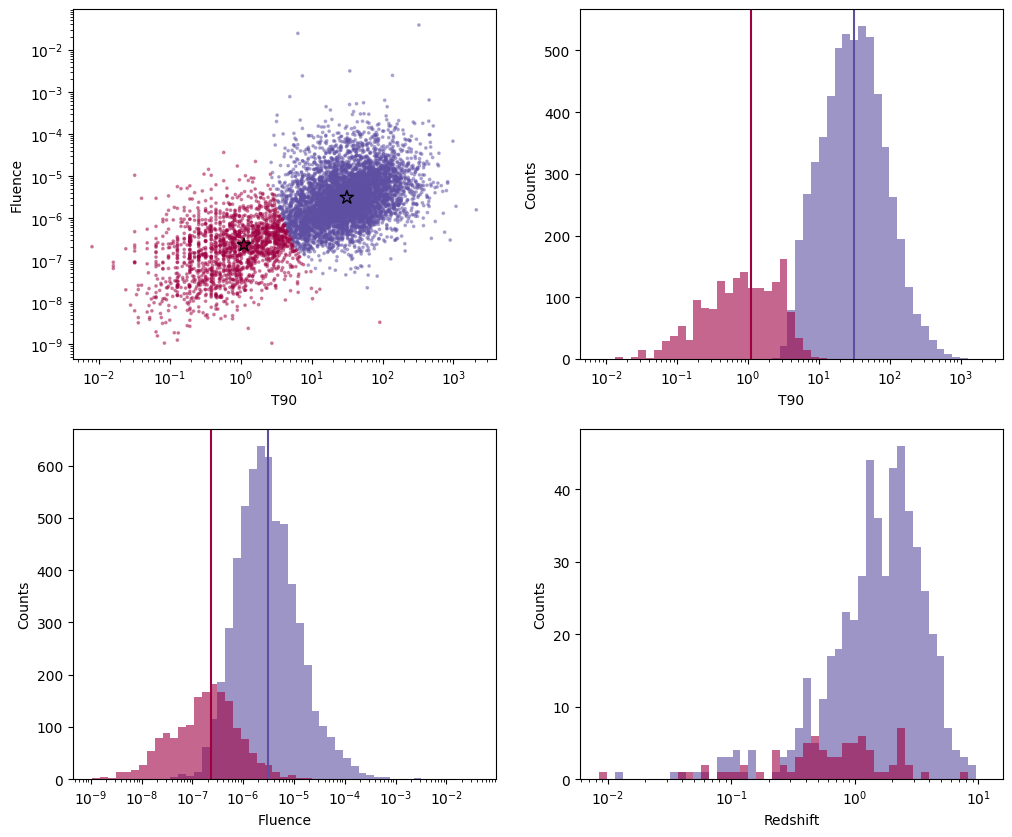

In [20]:
pipe = make_pipeline(
    StandardScaler(),
    GaussianMixture(n_components=2,
                    covariance_type='full',
                    random_state=42)
)

pipe.fit(data_reduced_log)

labels = pipe.predict(data_reduced_log)

gmm = pipe.named_steps['gaussianmixture']
scaler = pipe.named_steps['standardscaler']

centers = 10**scaler.inverse_transform(gmm.means_)
fig,ax=plt.subplots(2,2,figsize=(12,10))
colors = plt.cm.Spectral(np.linspace(1, 0, len(centers)))

for i in range(len(centers)):
    ax[0][0].scatter(T90[labels==i],fluence[labels==i],color=colors[i],alpha=0.4,s=3,linestyle='')
    ax[0][1].hist(T90[labels==i],bins=logbins_T90,alpha=0.6,color=colors[i])
    ax[0][1].axvline(centers[i,0],color=colors[i],alpha=1)
    ax[1][0].hist(fluence[labels==i],bins=logbins_flu,alpha=0.6,color=colors[i])
    ax[1][0].axvline(centers[i,1],color=colors[i],alpha=1)
    ax[1][1].hist(redshift[labels==i],bins=logbins_red,alpha=0.6,color=colors[i])
ax[0][0].scatter(centers[:,0],centers[:,1],marker='*',edgecolors='black',c=colors[0:len(centers)],s=100,label='Centers')
ax[0][0].set(xscale='log',yscale='log',xlabel='T90',ylabel='Fluence')
ax[0][1].set(xscale='log',xlabel='T90',ylabel='Counts')
ax[1][0].set(xscale='log',xlabel='Fluence',ylabel='Counts')
ax[1][1].set(xscale='log',xlabel='Redshift',ylabel='Counts')
print('Probability of the blue cluster: {:.2f}%'.format(100*np.count_nonzero(labels==0)/len(labels)),
      '\nProbability of the red cluster: {:.2f}%'.format(100*np.count_nonzero(labels==1)/len(labels)))

[None, Text(0.5, 0, 'Redshift'), Text(0, 0.5, 'Counts')]

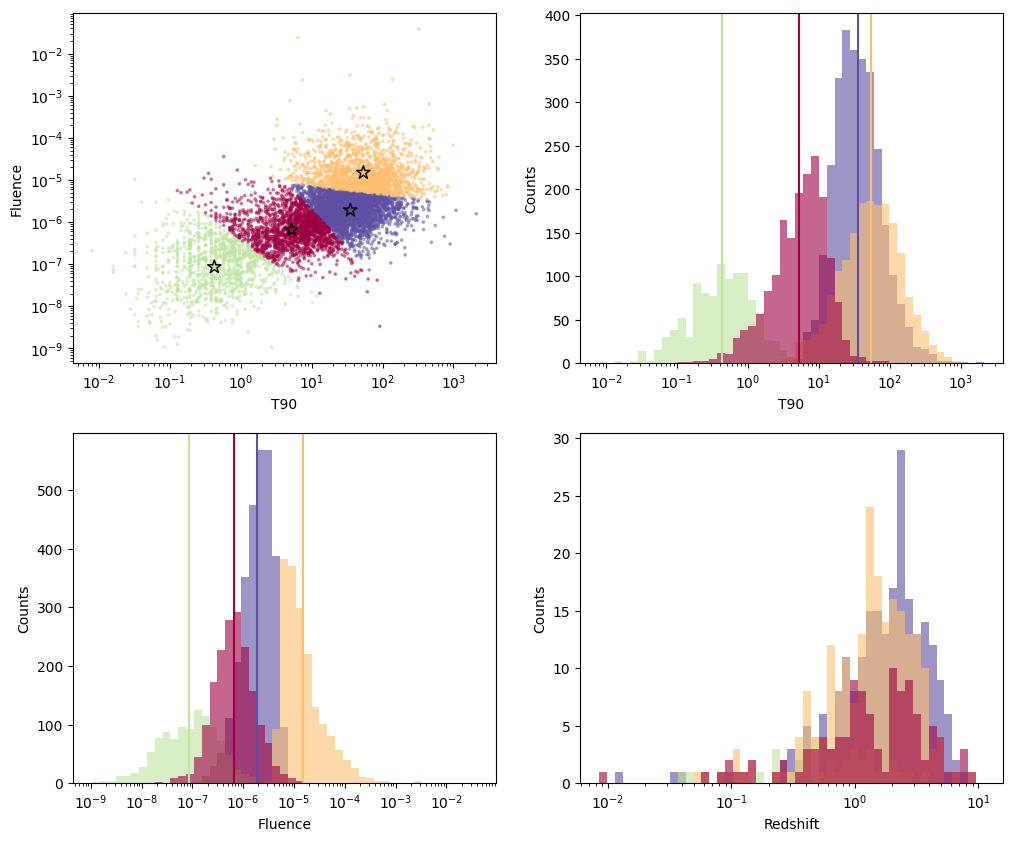

In [22]:
# let's try to fit the datas using more clusters
n_clus=4

pipe = make_pipeline(
    StandardScaler(),
    KMeans(n_clusters=n_clus, n_init='auto', random_state=42)
)
pipe.fit(data_reduced_log)

clf = pipe.named_steps['kmeans']
scaler = pipe.named_steps['standardscaler']

centers = 10**scaler.inverse_transform(clf.cluster_centers_) 

labels = pipe.predict(data_reduced_log)


fig,ax=plt.subplots(2,2,figsize=(12,10))
colors = plt.cm.Spectral(np.linspace(1, 0, len(centers)))

for i in range(len(centers)):
    ax[0][0].scatter(T90[labels==i],fluence[labels==i],color=colors[i],alpha=0.4,s=3,linestyle='')
    ax[0][1].hist(T90[labels==i],bins=logbins_T90,alpha=0.6,color=colors[i])
    ax[0][1].axvline(centers[i,0],color=colors[i],alpha=1)
    ax[1][0].hist(fluence[labels==i],bins=logbins_flu,alpha=0.6,color=colors[i])
    ax[1][0].axvline(centers[i,1],color=colors[i],alpha=1)
    ax[1][1].hist(redshift[labels==i],bins=logbins_red,alpha=0.6,color=colors[i])
ax[0][0].scatter(centers[:,0],centers[:,1],marker='*',edgecolors='black',c=colors[0:len(centers)],s=100,label='Centers')
ax[0][0].set(xscale='log',yscale='log',xlabel='T90',ylabel='Fluence')
ax[0][1].set(xscale='log',xlabel='T90',ylabel='Counts')
ax[1][0].set(xscale='log',xlabel='Fluence',ylabel='Counts')
ax[1][1].set(xscale='log',xlabel='Redshift',ylabel='Counts')